In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import os
import joblib
import xgboost as xgb
from xgboost.callback import EarlyStopping
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.metrics import (
    precision_score, recall_score, f1_score, classification_report,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTENC
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/train_feeds.joblib /content/
!cp /content/drive/MyDrive/train_ads.joblib /content/
!cp /content/drive/MyDrive/D_processed.joblib /content/
!cp /content/drive/MyDrive/D1_synth_v1.csv /content/
!cp /content/drive/MyDrive/D2_synth_v1.csv /content/
!cp /content/drive/MyDrive/D3_synth_v1.csv /content/
!cp /content/drive/MyDrive/D4_synth_v1.csv /content/
!cp /content/drive/MyDrive/D5_synth_v1.csv /content/
!cp /content/drive/MyDrive/D6_synth_v1.csv /content/
!cp /content/drive/MyDrive/synthetic_D1_10000.csv /content/
!cp /content/drive/MyDrive/synthetic_D2_10000.csv /content/
!cp /content/drive/MyDrive/synthetic_D3_10000.csv /content/
!cp /content/drive/MyDrive/synthetic_D4_10000_v1.csv /content/
!cp /content/drive/MyDrive/synthetic_D5_10000_v1.csv /content/
!cp /content/drive/MyDrive/synthetic_D6_10000_v1.csv /content/

In [ ]:
train_feeds = joblib.load('/content/train_feeds.joblib')
train_ads = joblib.load('/content/train_ads.joblib')
D_processed = joblib.load('/content/D_processed.joblib')

### Data Analysis Set Up

In [ ]:
D_processed.keys()

dict_keys(['D1', 'D2', 'D3', 'D4', 'D5', 'D6'])

In [ ]:
D_combined = pd.concat(D_processed.values(), ignore_index = True)

D_combined.shape

(54823, 19)

In [ ]:
# Calculate number of online instances per user
instances_per_user = train_ads.groupby(['user_id']).size()

# Calculate the sum of 'label' (clicks) for each user
clicks_per_user = train_ads.groupby(['user_id'])['label'].sum()

# Average click rate for each user
average_click_rate = clicks_per_user / instances_per_user

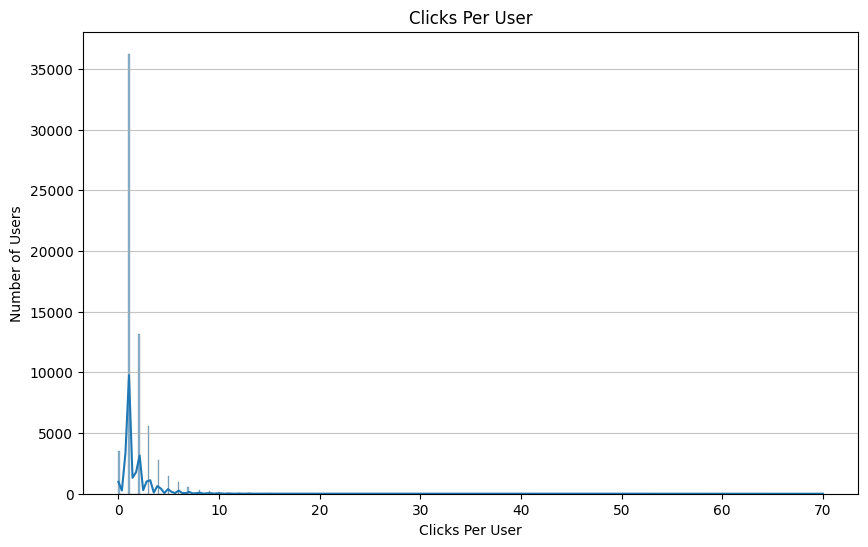

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of clicks per user
plt.figure(figsize=(10, 6))
sns.histplot(clicks_per_user, bins=500, kde=True)
plt.title('Clicks Per User')
plt.xlabel('Clicks Per User')
plt.ylabel('Number of Users')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
# Convert pt_d to datetime for completeness
train_ads["pt_d"] = pd.to_datetime(train_ads["pt_d"], format="%Y%m%d%H%M")
train_ads = train_ads.sort_values("pt_d").reset_index(drop=True)

# STEP 2: Find the top 6 task_id subgroups (D1–D6)
print("STEP 2: Building D1–D6 (top 6 task_ids, then user-level pruning)")

task_id_counts = train_ads["task_id"].value_counts()
top_6_task_ids = task_id_counts.head(6).index.tolist()

print("\nTop 6 task_ids by frequency:")
for i, t in enumerate(top_6_task_ids, 1):
    print(f"  D{i}: task_id={t}  ({task_id_counts[t]:,} rows)")

D_sets = {}          # pruned D1–D6 stored here
D_stats = []         # for a little summary table

for i, t_id in enumerate(top_6_task_ids, 1):
    print(f"\n==================== D{i}: task_id = {t_id} ====================")

    # ---- 2a. subset for this task_id (original subgroup) ----
    df_t = train_ads[train_ads["task_id"] == t_id].copy()
    ctr_before = df_t["label"].mean()

    print(f"Rows before pruning: {len(df_t):,}")
    print(f"CTR before pruning:  {ctr_before:.4f} ({100*ctr_before:.2f}%)")

    # ---- 2b. keep only users who have EVER clicked in THIS subgroup ----
    users_clicked = (
        df_t.groupby("user_id")["label"].any()
        .pipe(lambda s: s[s])           # keep True
        .index
    )

    df_pruned = df_t[df_t["user_id"].isin(users_clicked)].copy()
    ctr_after = df_pruned["label"].mean()

    print(f"Rows after pruning:  {len(df_pruned):,}")
    print(f"CTR after pruning:   {ctr_after:.4f} ({100*ctr_after:.2f}%)")

    # store
    D_sets[f"D{i}"] = df_pruned
    D_stats.append({
        "Dataset": f"D{i}",
        "task_id": t_id,
        "rows_before": len(df_t),
        "rows_after": len(df_pruned),
        "ctr_before": ctr_before,
        "ctr_after": ctr_after,
    })

# Optional: see a small summary like the slide’s table
D_stats_df = pd.DataFrame(D_stats)
print("\nSummary of D1–D6:")
print(D_stats_df[["Dataset","task_id","rows_before","rows_after",
                  "ctr_before","ctr_after"]])

# STEP 3: Combine D1–D6 if you want ONE pruned dataset for modeling
print("STEP 3: Combine pruned D1–D6 into one dataset (for modeling)")

ads_pruned_all = pd.concat(D_sets.values(), ignore_index=True)

combined_ctr = ads_pruned_all["label"].mean()
print(f"Rows in combined pruned dataset: {len(ads_pruned_all):,}")
print(f"Users in combined pruned dataset: {ads_pruned_all['user_id'].nunique():,}")
print(f"CTR in combined pruned dataset:  {combined_ctr:.4f} ({100*combined_ctr:.2f}%)")

# From here on, use ads_pruned_all for feature engineering:
pruned_train_ads = ads_pruned_all.copy()

STEP 2: Building D1–D6 (top 6 task_ids, then user-level pruning)

Top 6 task_ids by frequency:
  D1: task_id=22100  (154,812 rows)
  D2: task_id=14584  (126,367 rows)
  D3: task_id=34382  (122,094 rows)
  D4: task_id=34975  (92,381 rows)
  D5: task_id=31941  (77,470 rows)
  D6: task_id=31996  (69,691 rows)

==================== D1: task_id = 22100 ====================
Rows before pruning: 154,812
CTR before pruning:  0.0018 (0.18%)
Rows after pruning:  4,628
CTR after pruning:   0.0607 (6.07%)

==================== D2: task_id = 14584 ====================
Rows before pruning: 126,367
CTR before pruning:  0.0148 (1.48%)
Rows after pruning:  29,359
CTR after pruning:   0.0637 (6.37%)

==================== D3: task_id = 34382 ====================
Rows before pruning: 122,094
CTR before pruning:  0.0016 (0.16%)
Rows after pruning:  2,724
CTR after pruning:   0.0712 (7.12%)

==================== D4: task_id = 34975 ====================
Rows before pruning: 92,381
CTR before pruning:  0.0019

In [ ]:
# Calculate number of online instances per user
instances_per_user = pruned_train_ads.groupby(['user_id']).size()

# Calculate the sum of 'label' (clicks) for each user
clicks_per_user = pruned_train_ads.groupby(['user_id'])['label'].sum()

# Average click rate for each user
average_click_rate = clicks_per_user / instances_per_user

In [ ]:
results = []
thresholds = np.linspace(0.01, 0.1, num = 10)

for thresh in thresholds:
  higher_click_rate_users = average_click_rate[average_click_rate > thresh] # Corrected filter
  higher_click_rate_users_indices = higher_click_rate_users.index

  higher_pruned_train_ads = pruned_train_ads[pruned_train_ads['user_id'].isin(higher_click_rate_users_indices)]

  label_counts = higher_pruned_train_ads['label'].value_counts(normalize=True)

  no_click_proportion = label_counts.get(0, 0) # Get proportion of 0, default to 0 if not present
  click_proportion = label_counts.get(1, 0)   # Get proportion of 1, default to 0 if not present
  num_users_left = len(higher_click_rate_users_indices)

  results.append({
      'threshold': thresh,
      'no-click (0)': no_click_proportion,
      'click (1)': click_proportion,
      'num users left': num_users_left
  })

threshold_df = pd.DataFrame(results)
display(threshold_df)

,threshold,no-click (0),click (1),num users left
0,0.01,0.900960,0.099040,4093
1,0.02,0.879922,0.120078,3950
2,0.03,0.855660,0.144340,3757
3,0.04,0.825749,0.174251,3539
4,0.05,0.794105,0.205895,3342
5,0.06,0.766017,0.233983,3190
6,0.07,0.734753,0.265247,3044
7,0.08,0.705078,0.294922,2926
8,0.09,0.686050,0.313950,2855
9,0.10,0.647123,0.352877,2705


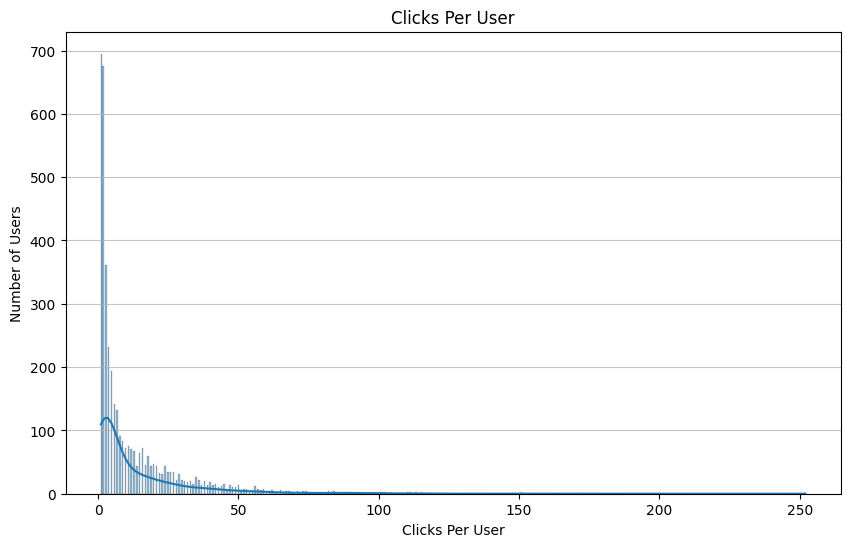

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of clicks per user
plt.figure(figsize=(10, 6))
sns.histplot(instances_per_user, bins=500, kde=True)
plt.title('Clicks Per User')
plt.xlabel('Clicks Per User')
plt.ylabel('Number of Users')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
pruned_train_ads.head()

,log_id,label,user_id,age,gender,residence,city,city_rank,series_dev,series_group,...,ad_click_list_v001,ad_click_list_v002,ad_click_list_v003,ad_close_list_v001,ad_close_list_v002,ad_close_list_v003,pt_d,u_newsCatInterestsST,u_refreshTimes,u_feedLifeCycle
0,1131711,0,247105,3,2,11,169,2,16,5,...,12092^21493^26644^14606^34975,1189^1036^1097^1964^1562,152^312^309^246^301,35034^17713^24125^15169,1542^1964^1097^1795,152,2022-06-03 01:01:00,98^65^108^50^140,9,17
1,1131737,0,247105,3,2,11,169,2,16,5,...,12092^21493^26644^14606^34975,1189^1036^1097^1964^1562,152^312^309^246^301,35034^17713^24125^15169,1542^1964^1097^1795,152,2022-06-03 01:01:00,98^65^108^50^140,9,17
2,1131714,0,247105,3,2,11,169,2,16,5,...,12092^21493^26644^14606^34975,1189^1036^1097^1964^1562,152^312^309^246^301,35034^17713^24125^15169,1542^1964^1097^1795,152,2022-06-03 01:01:00,98^65^108^50^140,9,17
3,1140732,0,208905,8,2,42,410,2,21,4,...,28403^20581^18365^13230^18473,1577^1199^1636^1516^1408,350^190^103^162^306,24107,1218,173,2022-06-03 01:02:00,98^78^98^205^105,8,11
4,1140771,0,208905,8,2,42,410,2,21,4,...,28403^20581^18365^13230^18473,1577^1199^1636^1516^1408,350^190^103^162^306,24107,1218,173,2022-06-03 01:02:00,98^78^98^205^105,8,11


### Caret Information Removal


In [ ]:
all_ad_click_v001_codes = set()

for entry in pruned_train_ads['ad_click_list_v001']:
    if isinstance(entry, str) and entry:
        codes = entry.split('^')
        for code_str in codes:
            try:
                all_ad_click_v001_codes.add(int(code_str))
            except ValueError:
                # Handle cases where conversion to int might fail (e.g., empty string after split)
                continue

list_ad_click_v001_codes = list(all_ad_click_v001_codes)
print(f"Number of unique ad_click_list_v001 codes: {len(list_ad_click_v001_codes)}")
print(f"First 10 unique ad_click_list_v001 codes: {list_ad_click_v001_codes[:10]}")

Number of unique ad_click_list_v001 codes: 4930
First 10 unique ad_click_list_v001 codes: [32773, 32776, 32784, 32787, 32796, 32797, 32798, 32803, 32814, 32817]


In [ ]:
min_ad_click_v001 = min(list_ad_click_v001_codes)
max_ad_click_v001 = max(list_ad_click_v001_codes)

print(f"Range for ad_click_list_v001: [{min_ad_click_v001}, {max_ad_click_v001}]")

Range for ad_click_list_v001: [10009, 36353]


In [ ]:
all_ad_click_v002_codes = set()

for entry in pruned_train_ads['ad_click_list_v002']:
    if isinstance(entry, str) and entry:
        codes = entry.split('^')
        for code_str in codes:
            try:
                all_ad_click_v002_codes.add(int(code_str))
            except ValueError:
                continue

list_ad_click_v002_codes = list(all_ad_click_v002_codes)
print(f"Number of unique ad_click_list_v002 codes: {len(list_ad_click_v002_codes)}")
print(f"First 10 unique ad_click_list_v002 codes: {list_ad_click_v002_codes[:10]}")

Number of unique ad_click_list_v002 codes: 693
First 10 unique ad_click_list_v002 codes: [2048, 2051, 2054, 2056, 2057, 2061, 2064, 2065, 2066, 2067]


In [ ]:
min_ad_click_v002 = min(list_ad_click_v002_codes)
max_ad_click_v002 = max(list_ad_click_v002_codes)

print(f"Range for ad_click_list_v002: [{min_ad_click_v002}, {max_ad_click_v002}]")

Range for ad_click_list_v002: [1001, 2081]


In [ ]:
all_ad_click_v003_codes = set()

for entry in pruned_train_ads['ad_click_list_v003']:
    if isinstance(entry, str) and entry:
        codes = entry.split('^')
        for code_str in codes:
            try:
                all_ad_click_v003_codes.add(int(code_str))
            except ValueError:
                continue

list_ad_click_v003_codes = list(all_ad_click_v003_codes)
print(f"Number of unique ad_click_list_v003 codes: {len(list_ad_click_v003_codes)}")
print(f"First 10 unique ad_click_list_v003 codes: {list_ad_click_v003_codes[:10]}")

Number of unique ad_click_list_v003 codes: 163
First 10 unique ad_click_list_v003 codes: [102, 103, 106, 110, 111, 112, 114, 116, 117, 121]


In [ ]:
min_ad_click_v003 = min(list_ad_click_v003_codes)
max_ad_click_v003 = max(list_ad_click_v003_codes)

print(f"Range for ad_click_list_v003: [{min_ad_click_v003}, {max_ad_click_v003}]")

Range for ad_click_list_v003: [102, 375]


In [ ]:
all_u_newsCatInterestsST_codes = set()

for entry in pruned_train_ads['u_newsCatInterestsST']:
    if isinstance(entry, str) and entry:
        codes = entry.split('^')
        for code_str in codes:
            try:
                all_u_newsCatInterestsST_codes.add(int(code_str))
            except ValueError:
                continue

list_u_newsCatInterestsST_codes = list(all_u_newsCatInterestsST_codes)
print(f"Number of unique u_newsCatInterestsST codes: {len(list_u_newsCatInterestsST_codes)}")
print(f"First 10 unique u_newsCatInterestsST codes: {list_u_newsCatInterestsST_codes[:10]}")

Number of unique u_newsCatInterestsST codes: 194
First 10 unique u_newsCatInterestsST codes: [0, 2, 3, 5, 6, 7, 8, 9, 10, 12]


In [ ]:
min_u_newsCatInterestsST = min(list_u_newsCatInterestsST_codes)
max_u_newsCatInterestsST = max(list_u_newsCatInterestsST_codes)

print(f"Range for u_newsCatInterestsST: [{min_u_newsCatInterestsST}, {max_u_newsCatInterestsST}]")

Range for u_newsCatInterestsST: [0, 220]


### Feature Hashing

In [ ]:
from sklearn.feature_extraction import FeatureHasher

# Helper function to convert the '^' separated string to a list of (feature_name, value) tuples
def parse_features_for_hasher(codes_string):
    if isinstance(codes_string, str) and codes_string:
        # Each code is a feature, and its value is 1 (indicating presence)
        return [(code, 1) for code in codes_string.split('^')]
    return []

# Set a reasonable number of output features for the hashers
n_features_ad_click_v001 = 256 # Increased for potentially more unique codes
n_features_ad_click_v002 = 32
n_features_ad_click_v003 = 8
n_features_u_newsCatInterestsST = 16

In [ ]:
# Apply hashing to ad_click_list_v001
hasher_ad_click_v001 = FeatureHasher(n_features=n_features_ad_click_v001, input_type='pair')

# Transform the column using the helper function
ad_click_v001_hashed = hasher_ad_click_v001.transform(
    pruned_train_ads['ad_click_list_v001'].apply(parse_features_for_hasher)
)

print(f"Shape of hashed ad_click_list_v001: {ad_click_v001_hashed.shape}")

Shape of hashed ad_click_list_v001: (54823, 256)


In [ ]:
# Apply hashing to ad_click_list_v002
hasher_ad_click_v002 = FeatureHasher(n_features=n_features_ad_click_v002, input_type='pair')

ad_click_v002_hashed = hasher_ad_click_v002.transform(
    pruned_train_ads['ad_click_list_v002'].apply(parse_features_for_hasher)
)

print(f"Shape of hashed ad_click_list_v002: {ad_click_v002_hashed.shape}")

Shape of hashed ad_click_list_v002: (54823, 32)


In [ ]:
# Apply hashing to ad_click_list_v003
hasher_ad_click_v003 = FeatureHasher(n_features=n_features_ad_click_v003, input_type='pair')

ad_click_v003_hashed = hasher_ad_click_v003.transform(
    pruned_train_ads['ad_click_list_v003'].apply(parse_features_for_hasher)
)

print(f"Shape of hashed ad_click_list_v003: {ad_click_v003_hashed.shape}")

Shape of hashed ad_click_list_v003: (54823, 8)


In [ ]:
# Apply hashing to u_newsCatInterestsST
hasher_u_newsCatInterestsST = FeatureHasher(n_features=n_features_u_newsCatInterestsST, input_type='pair')

u_newsCatInterestsST_hashed = hasher_u_newsCatInterestsST.transform(
    pruned_train_ads['u_newsCatInterestsST'].apply(parse_features_for_hasher)
)

print(f"Shape of hashed u_newsCatInterestsST: {u_newsCatInterestsST_hashed.shape}")

Shape of hashed u_newsCatInterestsST: (54823, 16)


In [ ]:
import scipy.sparse

# Convert sparse matrices to dense arrays for DataFrame conversion (be mindful of memory if datasets are very large)
ad_click_v001_df = pd.DataFrame(ad_click_v001_hashed.toarray(), columns=[f'task_IDs_hash_{i}' for i in range(n_features_ad_click_v001)])
ad_click_v002_df = pd.DataFrame(ad_click_v002_hashed.toarray(), columns=[f'advertiser_IDs_hash_{i}' for i in range(n_features_ad_click_v002)])
ad_click_v003_df = pd.DataFrame(ad_click_v003_hashed.toarray(), columns=[f'rec_apps_hash_{i}' for i in range(n_features_ad_click_v003)])
u_newsCatInterestsST_df = pd.DataFrame(u_newsCatInterestsST_hashed.toarray(), columns=[f'ST_Cat_hash_{i}' for i in range(n_features_u_newsCatInterestsST)])

# Concatenate the new hashed features DataFrames with pruned_train_ads
pruned_train_ads_with_hashed_features = pd.concat([
    pruned_train_ads.reset_index(drop=True), # Reset index to ensure proper concatenation
    ad_click_v001_df,
    ad_click_v002_df,
    ad_click_v003_df,
    u_newsCatInterestsST_df
], axis=1)

# Drop the original string columns that were hashed
columns_to_drop = [
    'ad_click_list_v001',
    'ad_click_list_v002',
    'ad_click_list_v003',
    'u_newsCatInterestsST'
]
pruned_train_ads_with_hashed_features = pruned_train_ads_with_hashed_features.drop(columns=columns_to_drop)

print("Shape of pruned_train_ads_with_hashed_features:", pruned_train_ads_with_hashed_features.shape)
display(pruned_train_ads_with_hashed_features.head())

Shape of pruned_train_ads_with_hashed_features: (54823, 343)


,log_id,label,user_id,age,gender,residence,city,city_rank,series_dev,series_group,...,ST_Cat_hash_6,ST_Cat_hash_7,ST_Cat_hash_8,ST_Cat_hash_9,ST_Cat_hash_10,ST_Cat_hash_11,ST_Cat_hash_12,ST_Cat_hash_13,ST_Cat_hash_14,ST_Cat_hash_15
0,1131711,0,247105,3,2,11,169,2,16,5,...,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,-1.0,-1.0,0.0
1,1131737,0,247105,3,2,11,169,2,16,5,...,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,-1.0,-1.0,0.0
2,1131714,0,247105,3,2,11,169,2,16,5,...,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,-1.0,-1.0,0.0
3,1140732,0,208905,8,2,42,410,2,21,4,...,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1140771,0,208905,8,2,42,410,2,21,4,...,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
pruned_train_ads_with_hashed_features["ST_Cat_hash_9"].unique()

array([ 1.,  2.,  0., -1., -3.,  4.,  3., -2.,  5.])

### Synthetic Data Comparison

In [ ]:
ctgan_d1 = pd.read_csv('/content/D1_synth_v1.csv')
ctgan_d2 = pd.read_csv('/content/D2_synth_v1.csv')
ctgan_d3 = pd.read_csv('/content/D3_synth_v1.csv')
ctgan_d4 = pd.read_csv('/content/D4_synth_v1.csv')
ctgan_d5 = pd.read_csv('/content/D5_synth_v1.csv')
ctgan_d6 = pd.read_csv('/content/D6_synth_v1.csv')

ctgan_dict = {
    "D1": ctgan_d1,
    "D2": ctgan_d2,
    "D3": ctgan_d3,
    "D4": ctgan_d4,
    "D5": ctgan_d5,
    "D6": ctgan_d6
}

rtf_d1 = pd.read_csv('/content/synthetic_D1_10000.csv')
rtf_d2 = pd.read_csv('/content/synthetic_D2_10000.csv')
rtf_d3 = pd.read_csv('/content/synthetic_D3_10000.csv')
rtf_d4 = pd.read_csv('/content/synthetic_D4_10000_v1.csv')
rtf_d5 = pd.read_csv('/content/synthetic_D5_10000_v1.csv')
rtf_d6 = pd.read_csv('/content/synthetic_D6_10000_v1.csv')

rtf_dict = {
    "D1": rtf_d1,
    "D2": rtf_d2,
    "D3": rtf_d3,
    "D4": rtf_d4,
    "D5": rtf_d5,
    "D6": rtf_d6
}

In [ ]:
D_combined_ctgan = pd.concat(ctgan_dict.values(), ignore_index = True)
D_combined_rtf = pd.concat(rtf_dict.values(), ignore_index = True)

print(D_combined_ctgan.shape, D_combined_rtf.shape)

(60000, 19) (60000, 19)


In [ ]:
print("Columns in D_combined:")
print(D_combined.columns.tolist())

print("Columns in D_combined_ctgan:")
print(D_combined_ctgan.columns.tolist())

print("Columns in D_combined_rtf:")
print(D_combined_rtf.columns.tolist())

Columns in D_combined:
['label', 'age', 'gender', 'residence', 'city', 'city_rank', 'series_dev', 'series_group', 'emui_dev', 'device_name', 'device_size', 'net_type', 'creat_type_cd', 'slot_id', 'u_refreshTimes', 'u_feedLifeCycle', 'u_newsCatInterestsST_count', 'click_count_mean', 'close_count_mean']
Columns in D_combined_ctgan:
['label', 'age', 'gender', 'residence', 'city', 'city_rank', 'series_dev', 'series_group', 'emui_dev', 'device_name', 'device_size', 'net_type', 'creat_type_cd', 'slot_id', 'u_refreshTimes', 'u_feedLifeCycle', 'u_newsCatInterestsST_count', 'click_count_mean', 'close_count_mean']
Columns in D_combined_rtf:
['label', 'age', 'gender', 'residence', 'city', 'city_rank', 'series_dev', 'series_group', 'emui_dev', 'device_name', 'device_size', 'net_type', 'creat_type_cd', 'slot_id', 'u_refreshTimes', 'u_feedLifeCycle', 'u_newsCatInterestsST_count', 'click_count_mean', 'close_count_mean']


In [ ]:
D_combined_rtf.head()

,label,age,gender,residence,city,city_rank,series_dev,series_group,emui_dev,device_name,device_size,net_type,creat_type_cd,slot_id,u_refreshTimes,u_feedLifeCycle,u_newsCatInterestsST_count,click_count_mean,close_count_mean
0,0,2,2,26,275,4,16,5,28,262,2093,7,10,16,8,17,5,5.0000,1.0
1,0,7,2,18,186,2,21,4,30,125,1656,7,10,16,9,17,5,5.0000,1.0
2,0,3,2,16,352,2,30,3,11,343,1975,7,10,16,5,17,5,4.3333,1.0
3,0,3,3,41,406,2,11,8,29,213,1413,7,10,16,9,17,5,4.0000,1.0
4,0,5,2,20,372,5,11,8,36,302,2541,7,10,16,4,17,5,4.3333,1.0


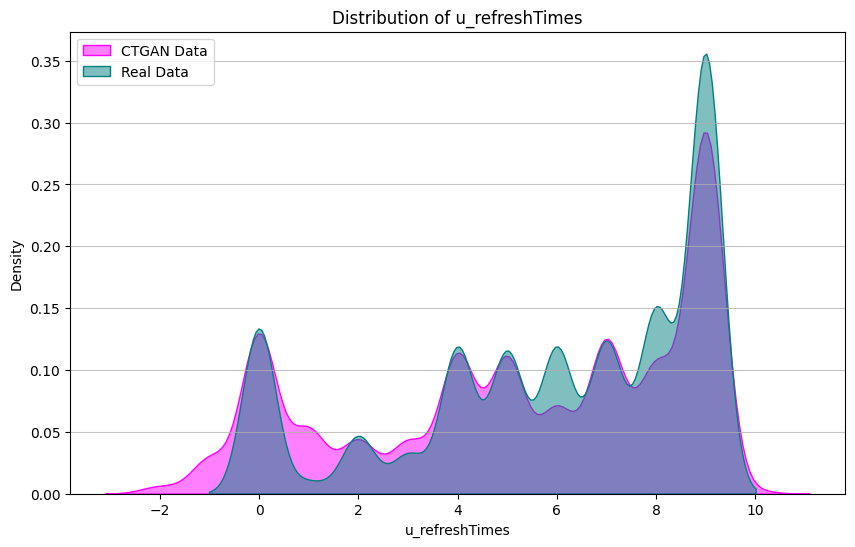

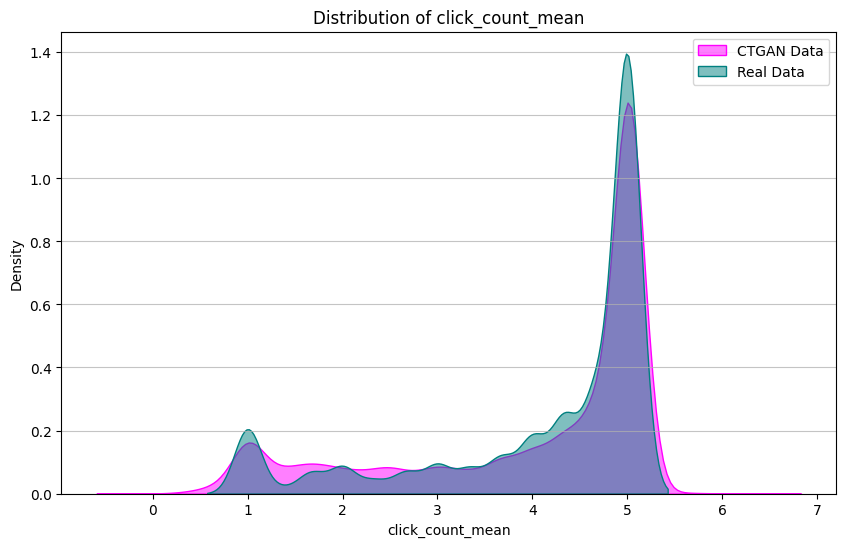

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of columns to compare
columns_to_compare = [
    'u_refreshTimes',
    'click_count_mean'
]

# Define custom colors
custom_palette = ['#008080', '#FF00FF'] # Teal, Gold

# Iterate through each column and generate KDE plots
for col in columns_to_compare:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(D_combined_ctgan[col], label='CTGAN Data', fill=True, alpha=0.5, color=custom_palette[1])
    sns.kdeplot(D_combined[col], label='Real Data', fill=True, alpha=0.5, color=custom_palette[0])
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(axis='y', alpha=0.75)
    plt.show()

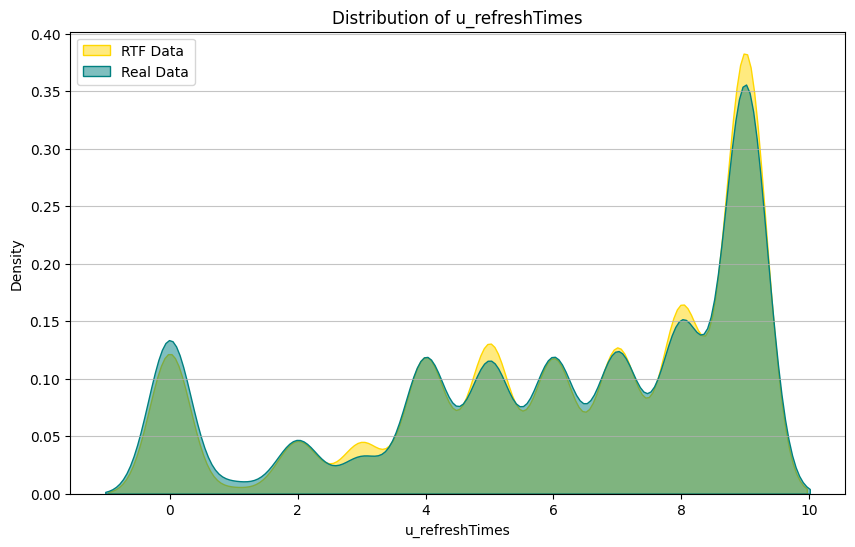

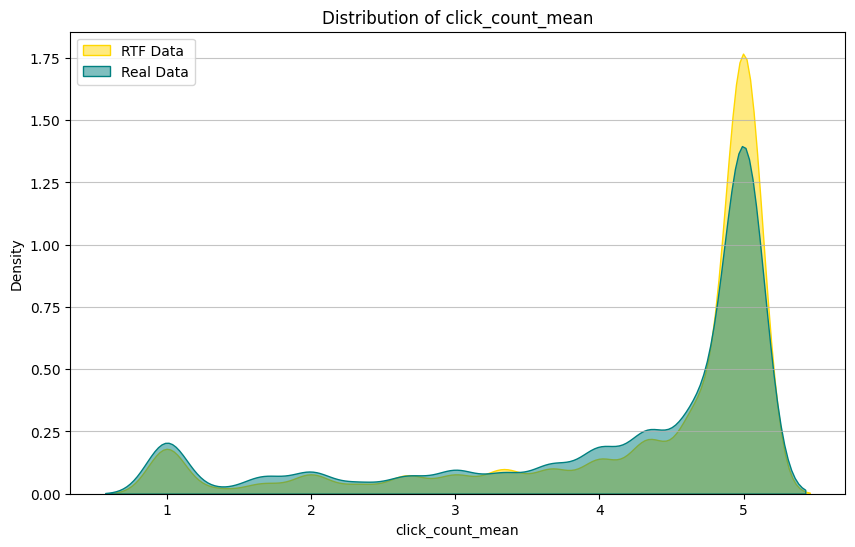

In [ ]:
# Define custom colors
custom_palette = ['#008080', '#FFD700'] # Teal, Gold

# Iterate through each column and generate KDE plots
for col in columns_to_compare:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(D_combined_rtf[col], label='RTF Data', fill=True, alpha=0.5, color=custom_palette[1])
    sns.kdeplot(D_combined[col], label='Real Data', fill=True, alpha=0.5, color=custom_palette[0])
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(axis='y', alpha=0.75)
    plt.show()

In [ ]:
categorical_cols = ['age', 'gender', 'residence', 'city', 'city_rank', 'series_dev', 'series_group', 'emui_dev', 'device_name', 'device_size', 'net_type', 'creat_type_cd', 'slot_id']
numerical_cols = ['u_refreshTimes', 'u_feedLifeCycle', 'u_newsCatInterestsST_count', 'click_count_mean', 'close_count_mean']

In [ ]:
import numpy as np
import pandas as pd

def total_variation_distance(p: np.ndarray, q: np.ndarray) -> float:
    """
    TVD between two discrete probability distributions p and q.
    Assumes p and q are 1D arrays that each sum to 1.
    """
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    return 0.5 * np.sum(np.abs(p - q))


def calculate_tvd_numerical(real_series, synth_series, bins: int = 50) -> float:
    """
    Approximate TVD between two numerical samples using a shared histogram.

    Parameters
    ----------
    real_series : array-like or pandas Series
        Real data.
    synth_series : array-like or pandas Series
        Synthetic data.
    bins : int, default=50
        Number of histogram bins.

    Returns
    -------
    float
        Total variation distance in [0, 1], or np.nan if both are empty.
    """
    # Convert to Series and drop NaNs
    real = pd.Series(real_series).dropna()
    synth = pd.Series(synth_series).dropna()

    # Handle empty cases
    if real.empty and synth.empty:
        return np.nan
    if real.empty or synth.empty:
        # One distribution exists, the other is "missing" -> treat as maximally different
        return 1.0

    # Get global min/max for consistent binning
    combined = pd.concat([real, synth])
    min_val, max_val = combined.min(), combined.max()

    # Degenerate case: everything is the same value
    if min_val == max_val:
        # Both concentrated at the same point -> TVD = 0
        if real.nunique() == 1 and synth.nunique() == 1 and real.iloc[0] == synth.iloc[0]:
            return 0.0
        # Otherwise treat as maximally different
        return 1.0

    # Histogram counts (not densities!)
    counts_real, bin_edges = np.histogram(real, bins=bins, range=(min_val, max_val), density=False)
    counts_synth, _ = np.histogram(synth, bins=bins, range=(min_val, max_val), density=False)

    # If somehow all counts are zero (shouldn't really happen), treat as undefined / maximally different
    if counts_real.sum() == 0 and counts_synth.sum() == 0:
        return np.nan
    if counts_real.sum() == 0 or counts_synth.sum() == 0:
        return 1.0

    # Convert counts to probabilities over bins
    p_real = counts_real / counts_real.sum()
    p_synth = counts_synth / counts_synth.sum()

    # TVD between the two discrete distributions over the bins
    return float(total_variation_distance(p_real, p_synth))


In [ ]:
import pandas as pd

tvd_results = []

for col in numerical_cols:
    tvd_ctgan = calculate_tvd_numerical(D_combined[col], D_combined_ctgan[col])
    tvd_rtf = calculate_tvd_numerical(D_combined[col], D_combined_rtf[col])

    tvd_results.append({
        'Column': col,
        'TVD_CTGAN': tvd_ctgan,
        'TVD_RTF': tvd_rtf
    })

tvd_df = pd.DataFrame(tvd_results)
display(tvd_df)

,Column,TVD_CTGAN,TVD_RTF
0,u_refreshTimes,0.101774,0.032038
1,u_feedLifeCycle,0.098143,0.014617
2,u_newsCatInterestsST_count,0.093361,0.014055
3,click_count_mean,0.377356,0.087038
4,close_count_mean,0.037952,0.008097


TVD Values close to 0 indicate identical distribtuions, close to 1 indicates completely disjointed.

In [ ]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    """
    Calculates Cramer's V for two categorical series.
    """
    contingency_table = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1

    if min_dim == 0:
        return 0.0 # Handle cases where one variable has only one category

    # Cramer's V formula
    v = np.sqrt(chi2 / (n * min_dim))
    return v

print("Cramer's V function defined.")

Cramer's V function defined.


In [ ]:
cramers_v_marginal_results = []

for col in categorical_cols:
    # Prepare data for CTGAN comparison
    temp_real_ctgan = pd.DataFrame({col: D_combined[col], 'source': 'real'})
    temp_synth_ctgan = pd.DataFrame({col: D_combined_ctgan[col], 'source': 'ctgan'})
    combined_for_marginal_ctgan = pd.concat([temp_real_ctgan, temp_synth_ctgan])

    # Calculate Cramer's V for CTGAN
    v_ctgan = cramers_v(combined_for_marginal_ctgan[col], combined_for_marginal_ctgan['source'])

    # Prepare data for RTF comparison
    temp_real_rtf = pd.DataFrame({col: D_combined[col], 'source': 'real'})
    temp_synth_rtf = pd.DataFrame({col: D_combined_rtf[col], 'source': 'rtf'})
    combined_for_marginal_rtf = pd.concat([temp_real_rtf, temp_synth_rtf])

    # Calculate Cramer's V for RTF
    v_rtf = cramers_v(combined_for_marginal_rtf[col], combined_for_marginal_rtf['source'])

    cramers_v_marginal_results.append({
        'Column': col,
        'CramersV_CTGAN_Marginal': v_ctgan,
        'CramersV_RTF_Marginal': v_rtf
    })

cramers_v_marginal_df = pd.DataFrame(cramers_v_marginal_results)
display(cramers_v_marginal_df)


,Column,CramersV_CTGAN_Marginal,CramersV_RTF_Marginal
0,age,0.101708,0.094325
1,gender,0.026075,0.034176
2,residence,0.127201,0.135330
3,city,0.211577,0.230909
4,city_rank,0.083767,0.086042
5,series_dev,0.250547,0.232614
6,series_group,0.222466,0.221468
7,emui_dev,0.192691,0.182428
8,device_name,0.321082,0.319287
9,device_size,0.350771,0.368568


0 indicates no association between the two cateogrical variables
1 indicates a perfect association

Anything 0.3 or greater is generally considered strong



In [ ]:
import itertools

cramers_v_pairwise_results = {
    'Real_Data': pd.DataFrame(index=categorical_cols, columns=categorical_cols),
    'CTGAN_Data': pd.DataFrame(index=categorical_cols, columns=categorical_cols),
    'RTF_Data': pd.DataFrame(index=categorical_cols, columns=categorical_cols)
}

for i, col1 in enumerate(categorical_cols):
    for col2 in categorical_cols[i+1:]:
        # Real Data
        v_real = cramers_v(D_combined[col1], D_combined[col2])
        cramers_v_pairwise_results['Real_Data'].loc[col1, col2] = v_real
        cramers_v_pairwise_results['Real_Data'].loc[col2, col1] = v_real # Symmetric

        # CTGAN Data
        v_ctgan = cramers_v(D_combined_ctgan[col1], D_combined_ctgan[col2])
        cramers_v_pairwise_results['CTGAN_Data'].loc[col1, col2] = v_ctgan
        cramers_v_pairwise_results['CTGAN_Data'].loc[col2, col1] = v_ctgan # Symmetric

        # RTF Data
        v_rtf = cramers_v(D_combined_rtf[col1], D_combined_rtf[col2])
        cramers_v_pairwise_results['RTF_Data'].loc[col1, col2] = v_rtf
        cramers_v_pairwise_results['RTF_Data'].loc[col2, col1] = v_rtf # Symmetric

print("Cramer's V Pairwise for Real Data:")
display(cramers_v_pairwise_results['Real_Data'])

print("\nCramer's V Pairwise for CTGAN Data:")
display(cramers_v_pairwise_results['CTGAN_Data'])

print("\nCramer's V Pairwise for RTF Data:")
display(cramers_v_pairwise_results['RTF_Data'])

Cramer's V Pairwise for Real Data:


,age,gender,residence,city,city_rank,series_dev,series_group,emui_dev,device_name,device_size,net_type,creat_type_cd,slot_id
age,NaN,0.661343,0.407439,0.529992,0.539626,0.430747,0.434821,0.441608,0.405174,0.353907,0.078065,0.272001,0.147224
gender,0.661343,NaN,0.675299,0.713261,0.638113,0.658041,0.65057,0.648581,0.289571,0.271809,0.065845,0.103586,0.132077
residence,0.407439,0.675299,NaN,0.978784,0.751012,0.271485,0.433801,0.271017,0.354895,0.321956,0.104665,0.265866,0.097929
city,0.529992,0.713261,0.978784,NaN,1.0,0.460557,0.56683,0.457741,0.363181,0.274741,0.198133,0.453659,0.176483
city_rank,0.539626,0.638113,0.751012,1.0,NaN,0.548179,0.533804,0.534524,0.313317,0.306662,0.05112,0.174788,0.160637
series_dev,0.430747,0.658041,0.271485,0.460557,0.548179,NaN,1.0,0.539394,0.944686,0.598841,0.129259,0.491018,0.254876
series_group,0.434821,0.65057,0.433801,0.56683,0.533804,1.0,NaN,0.678904,0.89034,0.516262,0.123738,0.472035,0.416428
emui_dev,0.441608,0.648581,0.271017,0.457741,0.534524,0.539394,0.678904,NaN,0.833843,0.450845,0.129425,0.392745,0.170991
device_name,0.405174,0.289571,0.354895,0.363181,0.313317,0.944686,0.89034,0.833843,NaN,0.482741,0.219644,0.637835,0.232954
device_size,0.353907,0.271809,0.321956,0.274741,0.306662,0.598841,0.516262,0.450845,0.482741,NaN,0.321885,0.602855,0.282271



Cramer's V Pairwise for CTGAN Data:


,age,gender,residence,city,city_rank,series_dev,series_group,emui_dev,device_name,device_size,net_type,creat_type_cd,slot_id
age,NaN,0.301697,0.165754,0.202364,0.247155,0.181911,0.191288,0.173149,0.137918,0.153767,0.077477,0.202326,0.148365
gender,0.301697,NaN,0.294908,0.324514,0.30455,0.300755,0.294538,0.29174,0.154293,0.150489,0.068613,0.06056,0.132754
residence,0.165754,0.294908,NaN,0.13293,0.256562,0.107001,0.178762,0.100625,0.093456,0.134106,0.107846,0.200855,0.074127
city,0.202364,0.324514,0.13293,NaN,0.288884,0.166827,0.227912,0.16464,0.13657,0.202448,0.190486,0.397911,0.159464
city_rank,0.247155,0.30455,0.256562,0.288884,NaN,0.257177,0.251983,0.258389,0.160623,0.177887,0.076771,0.132251,0.154118
series_dev,0.181911,0.300755,0.107001,0.166827,0.257177,NaN,0.242967,0.132706,0.155791,0.172827,0.127431,0.36021,0.149658
series_group,0.191288,0.294538,0.178762,0.227912,0.251983,0.242967,NaN,0.199776,0.196149,0.18996,0.109524,0.311435,0.219742
emui_dev,0.173149,0.29174,0.100625,0.16464,0.258389,0.132706,0.199776,NaN,0.151119,0.165939,0.118356,0.303327,0.105399
device_name,0.137918,0.154293,0.093456,0.13657,0.160623,0.155791,0.196149,0.151119,NaN,0.194981,0.218475,0.51839,0.156735
device_size,0.153767,0.150489,0.134106,0.202448,0.177887,0.172827,0.18996,0.165939,0.194981,NaN,0.25054,0.6005,0.238628



Cramer's V Pairwise for RTF Data:


,age,gender,residence,city,city_rank,series_dev,series_group,emui_dev,device_name,device_size,net_type,creat_type_cd,slot_id
age,NaN,0.644977,0.45735,0.651804,0.536277,0.429712,0.416798,0.466062,0.526055,0.459285,0.065547,0.177812,0.114903
gender,0.644977,NaN,0.674503,0.757903,0.613099,0.644186,0.62656,0.6219,0.475503,0.372074,0.098046,0.066323,0.107333
residence,0.45735,0.674503,NaN,0.88766,0.749612,0.294608,0.466308,0.309293,0.43965,0.404991,0.124487,0.23568,0.094701
city,0.651804,0.757903,0.88766,NaN,0.994558,0.50295,0.667375,0.54867,0.400595,0.340173,0.268432,0.449892,0.211267
city_rank,0.536277,0.613099,0.749612,0.994558,NaN,0.547635,0.512004,0.53135,0.476051,0.429551,0.052162,0.134698,0.13893
series_dev,0.429712,0.644186,0.294608,0.50295,0.547635,NaN,0.999442,0.51844,0.861246,0.609519,0.128897,0.36405,0.188652
series_group,0.416798,0.62656,0.466308,0.667375,0.512004,0.999442,NaN,0.701793,0.900672,0.588626,0.1035,0.322189,0.294975
emui_dev,0.466062,0.6219,0.309293,0.54867,0.53135,0.51844,0.701793,NaN,0.803625,0.505502,0.125655,0.278337,0.130632
device_name,0.526055,0.475503,0.43965,0.400595,0.476051,0.861246,0.900672,0.803625,NaN,0.45116,0.278496,0.556168,0.213474
device_size,0.459285,0.372074,0.404991,0.340173,0.429551,0.609519,0.588626,0.505502,0.45116,NaN,0.337859,0.628238,0.287818


**Reasoning**:
Now, I will calculate the Pearson correlation matrices for the numerical columns for the real data (`D_combined`), CTGAN synthetic data (`D_combined_ctgan`), and RTF synthetic data (`D_combined_rtf`). This will allow for a quantitative comparison of the pairwise relationships between numerical features across the datasets.



In [ ]:
print("Pearson Correlation Matrix for Real Data:")
correlation_matrix_real = D_combined[numerical_cols].corr(method='pearson')
display(correlation_matrix_real)

print("\nPearson Correlation Matrix for CTGAN Data:")
correlation_matrix_ctgan = D_combined_ctgan[numerical_cols].corr(method='pearson')
display(correlation_matrix_ctgan)

print("\nPearson Correlation Matrix for RTF Data:")
correlation_matrix_rtf = D_combined_rtf[numerical_cols].corr(method='pearson')
display(correlation_matrix_rtf)

Pearson Correlation Matrix for Real Data:


,u_refreshTimes,u_feedLifeCycle,u_newsCatInterestsST_count,click_count_mean,close_count_mean
u_refreshTimes,1.000000,0.486066,0.485021,0.542095,0.106869
u_feedLifeCycle,0.486066,1.000000,0.490802,0.409159,0.048359
u_newsCatInterestsST_count,0.485021,0.490802,1.000000,0.485338,0.037383
click_count_mean,0.542095,0.409159,0.485338,1.000000,0.078590
close_count_mean,0.106869,0.048359,0.037383,0.078590,1.000000



Pearson Correlation Matrix for CTGAN Data:


,u_refreshTimes,u_feedLifeCycle,u_newsCatInterestsST_count,click_count_mean,close_count_mean
u_refreshTimes,1.000000,0.153984,0.217470,0.197879,-0.005253
u_feedLifeCycle,0.153984,1.000000,0.199838,0.158172,-0.006834
u_newsCatInterestsST_count,0.217470,0.199838,1.000000,0.258254,0.033123
click_count_mean,0.197879,0.158172,0.258254,1.000000,0.011587
close_count_mean,-0.005253,-0.006834,0.033123,0.011587,1.000000



Pearson Correlation Matrix for RTF Data:


,u_refreshTimes,u_feedLifeCycle,u_newsCatInterestsST_count,click_count_mean,close_count_mean
u_refreshTimes,1.000000,0.418972,0.423674,0.450929,0.126070
u_feedLifeCycle,0.418972,1.000000,0.412811,0.365322,0.051729
u_newsCatInterestsST_count,0.423674,0.412811,1.000000,0.424172,0.037450
click_count_mean,0.450929,0.365322,0.424172,1.000000,0.075531
close_count_mean,0.126070,0.051729,0.037450,0.075531,1.000000


**Reasoning**:
Now that the Pearson correlation matrices have been calculated, I will visualize them using heatmaps for better interpretability and comparison across the real and synthetic datasets. This will help in understanding how well each synthetic model preserves the numerical relationships present in the real data.



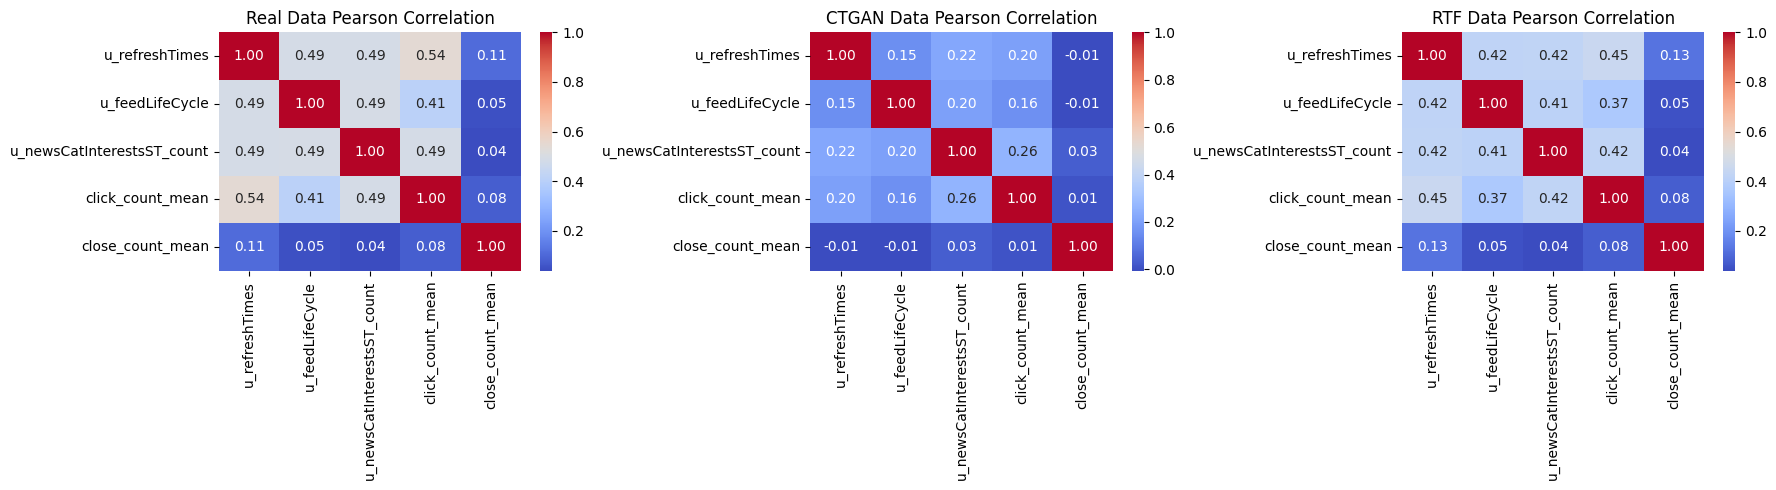

In [ ]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.heatmap(correlation_matrix_real, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Real Data Pearson Correlation')

plt.subplot(1, 3, 2)
sns.heatmap(correlation_matrix_ctgan, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('CTGAN Data Pearson Correlation')

plt.subplot(1, 3, 3)
sns.heatmap(correlation_matrix_rtf, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('RTF Data Pearson Correlation')

plt.tight_layout()
plt.show()

In [ ]:
D_combined.shape, D_combined_ctgan.shape, D_combined_rtf.shape

((54823, 19), (60000, 19), (60000, 19))

In [ ]:
# Create copies of the synthetic dataframes and add the 'synth' column with value 1
df_ctgan_synth = D_combined_ctgan.copy()
df_ctgan_synth['synth'] = 1

df_rtf_synth = D_combined_rtf.copy()
df_rtf_synth['synth'] = 1

# Create a copy of the original dataframe and add the 'synth' column with value 0
df_original = D_combined.copy()
df_original['synth'] = 0

# Concatenate all three dataframes
synth_real_combined = pd.concat([df_original, df_ctgan_synth, df_rtf_synth], ignore_index=True)

print("Shape of the combined dataframe:", synth_real_combined.shape)
display(synth_real_combined.head())

Shape of the combined dataframe: (174823, 20)


,label,age,gender,residence,city,city_rank,series_dev,series_group,emui_dev,device_name,device_size,net_type,creat_type_cd,slot_id,u_refreshTimes,u_feedLifeCycle,u_newsCatInterestsST_count,click_count_mean,close_count_mean,synth
0,0,3,2,11,169,2,16,5,28,240,2579,7,10,16,9,17,5,5.0,3.0,0
1,0,3,2,11,169,2,16,5,28,240,2579,7,10,16,9,17,5,5.0,3.0,0
2,0,3,2,11,169,2,16,5,28,240,2579,7,10,16,9,17,5,5.0,3.0,0
3,0,8,2,42,410,2,21,4,12,310,1171,7,10,16,8,11,5,5.0,1.0,0
4,0,8,2,42,410,2,21,4,12,310,1171,7,10,16,8,11,5,5.0,1.0,0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Define features (X) and target (y)
X = synth_real_combined.drop('synth', axis=1)
y = synth_real_combined['synth']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

# Initialize and train the Random Forest Classifier
# Using a small number of estimators for quicker execution in a notebook context
# For better performance, consider increasing n_estimators
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Shape of X_train: (122376, 19)
Shape of X_test: (52447, 19)
Shape of y_train: (122376,)
Shape of y_test: (52447,)

Accuracy Score: 0.850668293706027

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.72      0.75     16447
           1       0.88      0.91      0.89     36000

    accuracy                           0.85     52447
   macro avg       0.83      0.82      0.82     52447
weighted avg       0.85      0.85      0.85     52447



# Task
Calculate the absolute difference between the Pearson correlation matrix of the real data (`correlation_matrix_real`) and the Pearson correlation matrix of the CTGAN synthetic data (`correlation_matrix_ctgan`), and then calculate the absolute difference between the Pearson correlation matrix of the real data (`correlation_matrix_real`) and the Pearson correlation matrix of the RTF synthetic data (`correlation_matrix_rtf`). Finally, visualize these absolute differences using heatmaps and summarize which synthetic model (CTGAN or RTF) more closely replicates the numerical feature relationships of the real data, highlighting any strong deviations.

## Calculate Absolute Correlation Differences for CTGAN

### Subtask:
Calculate the absolute difference between the Pearson correlation matrix of the real data (`correlation_matrix_real`) and the Pearson correlation matrix of the CTGAN synthetic data (`correlation_matrix_ctgan`). This will quantify the deviation in pairwise numerical feature relationships.


**Reasoning**:
To quantify the deviation between the real and CTGAN synthetic data, I will calculate the absolute difference between their Pearson correlation matrices, as specified in the instructions.



In [ ]:
numerical_cols = ['u_refreshTimes', 'u_feedLifeCycle', 'u_newsCatInterestsST_count', 'click_count_mean', 'close_count_mean']

correlation_matrix_real = D_combined[numerical_cols].corr(method='pearson')
correlation_matrix_ctgan = D_combined_ctgan[numerical_cols].corr(method='pearson')

correlation_diff_ctgan = abs(correlation_matrix_real - correlation_matrix_ctgan)

print("Absolute Difference in Pearson Correlation (Real vs. CTGAN):")
display(correlation_diff_ctgan)

Absolute Difference in Pearson Correlation (Real vs. CTGAN):


,u_refreshTimes,u_feedLifeCycle,u_newsCatInterestsST_count,click_count_mean,close_count_mean
u_refreshTimes,0.000000,0.332082,0.267551,0.344216,0.112122
u_feedLifeCycle,0.332082,0.000000,0.290964,0.250987,0.055193
u_newsCatInterestsST_count,0.267551,0.290964,0.000000,0.227084,0.004260
click_count_mean,0.344216,0.250987,0.227084,0.000000,0.067004
close_count_mean,0.112122,0.055193,0.004260,0.067004,0.000000


**Reasoning**:
I will visualize the `correlation_diff_ctgan` using a heatmap to clearly show the absolute differences in pairwise numerical feature relationships between the real data and the CTGAN synthetic data. This provides an intuitive way to identify the features where CTGAN's correlations deviate most from the real data.



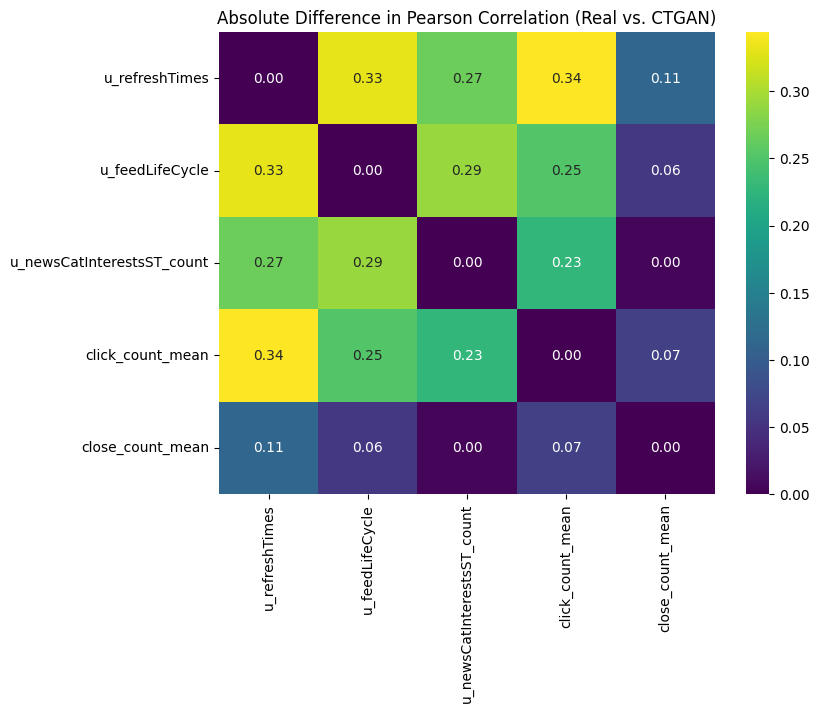

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_diff_ctgan, annot=True, cmap='viridis', fmt=".2f")
plt.title('Absolute Difference in Pearson Correlation (Real vs. CTGAN)')
plt.show()

**Reasoning**:
Now that the absolute difference in correlations between real and CTGAN data has been visualized, I will calculate the absolute difference between the Pearson correlation matrix of the real data and the RTF synthetic data to compare RTF's performance.



In [ ]:
correlation_matrix_rtf = D_combined_rtf[numerical_cols].corr(method='pearson')

correlation_diff_rtf = abs(correlation_matrix_real - correlation_matrix_rtf)

print("Absolute Difference in Pearson Correlation (Real vs. RTF):")
display(correlation_diff_rtf)

Absolute Difference in Pearson Correlation (Real vs. RTF):


,u_refreshTimes,u_feedLifeCycle,u_newsCatInterestsST_count,click_count_mean,close_count_mean
u_refreshTimes,0.000000,0.067094,0.061346,0.091166,0.019201
u_feedLifeCycle,0.067094,0.000000,0.077990,0.043837,0.003370
u_newsCatInterestsST_count,0.061346,0.077990,0.000000,0.061166,0.000067
click_count_mean,0.091166,0.043837,0.061166,0.000000,0.003060
close_count_mean,0.019201,0.003370,0.000067,0.003060,0.000000


**Reasoning**:
I will visualize the `correlation_diff_rtf` using a heatmap to clearly show the absolute differences in pairwise numerical feature relationships between the real data and the RTF synthetic data. This provides an intuitive way to compare RTF's performance against CTGAN's.



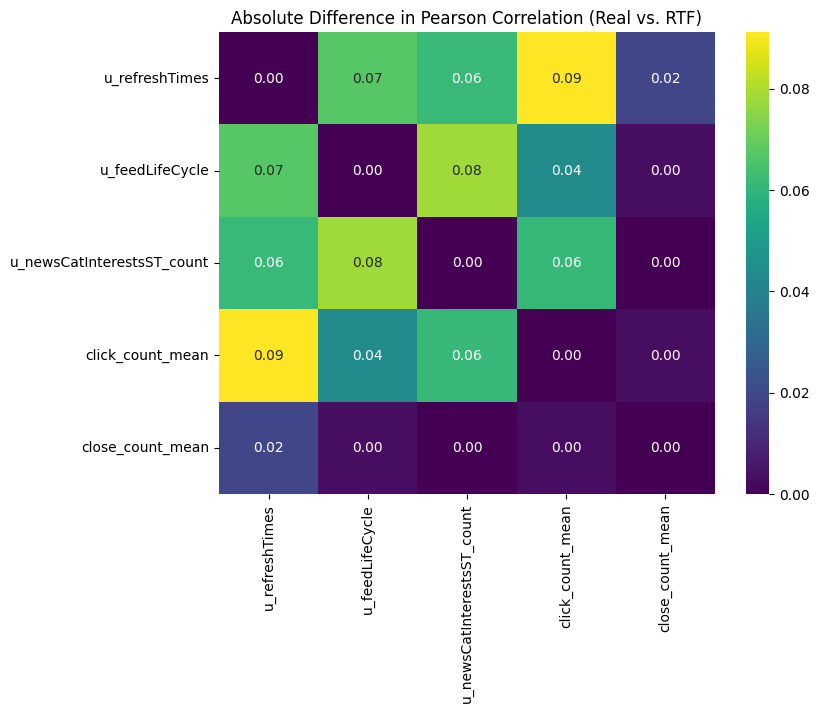

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_diff_rtf, annot=True, cmap='viridis', fmt=".2f")
plt.title('Absolute Difference in Pearson Correlation (Real vs. RTF)')
plt.show()

### Summary of Numerical Correlation Comparison

By comparing the absolute difference heatmaps for Pearson correlations:

*   **CTGAN vs. Real Data (`correlation_diff_ctgan`)**:
    The absolute differences in Pearson correlation between the real data and the CTGAN synthetic data show relatively high deviations for several pairs of features. For instance, the correlation between `u_refreshTimes` and `u_feedLifeCycle` deviates by approximately 0.33, and between `u_refreshTimes` and `click_count_mean` by about 0.34. This indicates that CTGAN struggled to accurately replicate the linear relationships between some numerical features present in the real dataset.

*   **RTF vs. Real Data (`correlation_diff_rtf`)**:
    In contrast, the absolute differences in Pearson correlation between the real data and the RTF synthetic data are generally much lower across all feature pairs. The maximum deviation appears to be around 0.09 (e.g., between `u_refreshTimes` and `click_count_mean`), which is significantly smaller than the deviations observed with CTGAN. This suggests that RTF was more successful in preserving the pairwise linear relationships of the numerical features.

**Conclusion**:
Based on the Pearson correlation analysis, the **RTF synthetic model more closely replicates the numerical feature relationships of the real data** compared to the CTGAN model. The absolute differences in correlations are consistently lower for RTF, indicating a better preservation of these statistical properties.

### Summary of Numerical Correlation Comparison

By comparing the absolute difference heatmaps for Pearson correlations:

*   **CTGAN vs. Real Data (`correlation_diff_ctgan`)**:
    The absolute differences in Pearson correlation between the real data and the CTGAN synthetic data show relatively high deviations for several pairs of features. For instance, the correlation between `u_refreshTimes` and `u_feedLifeCycle` deviates by approximately 0.33, and between `u_refreshTimes` and `click_count_mean` by about 0.34. This indicates that CTGAN struggled to accurately replicate the linear relationships between some numerical features present in the real dataset.

*   **RTF vs. Real Data (`correlation_diff_rtf`)**:
    In contrast, the absolute differences in Pearson correlation between the real data and the RTF synthetic data are generally much lower across all feature pairs. The maximum deviation appears to be around 0.09 (e.g., between `u_refreshTimes` and `click_count_mean`), which is significantly smaller than the deviations observed with CTGAN. This suggests that RTF was more successful in preserving the pairwise linear relationships of the numerical features.

**Conclusion**:
Based on the Pearson correlation analysis, the **RTF synthetic model more closely replicates the numerical feature relationships of the real data** compared to the CTGAN model. The absolute differences in correlations are consistently lower for RTF, indicating a better preservation of these statistical properties.

## Final Task

### Subtask:
Summarize the findings from the correlation difference analysis, highlighting which synthetic model (CTGAN or RTF) more closely replicates the numerical feature relationships of the real data, and identify any particularly strong deviations.


## Summary:

### Q&A
*   **Which synthetic model (CTGAN or RTF) more closely replicates the numerical feature relationships of the real data?**
    The RTF synthetic model more closely replicates the numerical feature relationships of the real data compared to the CTGAN model.

### Data Analysis Key Findings
*   **CTGAN Model Deviations**: The CTGAN synthetic data showed significant deviations in Pearson correlations compared to the real data. Notably, the absolute difference in correlation between `u_refreshTimes` and `u_feedLifeCycle` was approximately 0.33, and between `u_refreshTimes` and `click_count_mean` was about 0.34.
*   **RTF Model Superiority**: In contrast, the RTF synthetic data exhibited much lower absolute differences in Pearson correlations. The maximum deviation observed with RTF was around 0.09 (e.g., between `u_refreshTimes` and `click_count_mean`), which is considerably smaller than the deviations found with CTGAN.
*   **Overall Performance**: RTF consistently produced smaller absolute deviations across all feature pairs, indicating a better preservation of the real data's numerical statistical properties.

### Insights or Next Steps
*   RTF is a more suitable synthetic data generation model for tasks requiring high fidelity in numerical feature relationships.
*   Further investigation could involve comparing other statistical properties (e.g., distributions, higher-order moments) between the real and synthetic datasets to provide a more comprehensive evaluation.
